# Ungraded Lab: Cats vs. Dogs Class Activation Maps

You will again practice with CAMs in this lab and this time there will only be two classes: Cats and Dogs. You will be revisiting this exercise in this week's programming assignment so it's best if you become familiar with the steps discussed here, particularly in preprocessing the image and building the model.

## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

/home/mcc/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-07 11:36:44.566795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 11:36:44.684908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738924604.741415   52821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738924604.756295   52821 cuda_blas.cc:1418] Unable to reg

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

In [2]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

2025-02-07 11:36:49.491949: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]WARNING:absl:1738 images were corrupted and were skipped
I0000 00:00:1738924632.593457   52821 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9844 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Dataset cats_vs_dogs downloaded and prepared to /home/mcc/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The cell below will preprocess the images and create batches before feeding it to our model.

In [3]:
def augment_images(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

## Build the classifier

This will look familiar to you because it is almost identical to the previous model we built. The key difference is the output is just one unit that is sigmoid activated. This is because we're only dealing with two classes.

In [4]:
model = Sequential()

model.add(keras.Input(shape=(300,300,3)))
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,569 (381.13 KB)

 Trainable params: 97,569 (381.13 KB)

 Non-trainable params: 0 (0.00 B)

The loss can be adjusted from last time to deal with just two classes. For that, we pick `binary_crossentropy`.

In [5]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
model.fit(train_batches,epochs=25)

Epoch 1/25


2025-02-07 11:40:02.807398: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1738924804.025407   53124 service.cc:148] XLA service 0x7f1724007fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738924804.027808   53124 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-07 11:40:04.178498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738924804.435871   53124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/582 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4883 - loss: 0.6935

I0000 00:00:1738924807.740653   53124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/582 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5318 - loss: 0.6899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.5343 - loss: 0.6888

212/582 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.5354 - loss: 0.6884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5413 - loss: 0.6857

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5541 - loss: 0.6795

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5548 - loss: 0.6792

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5553 - loss: 0.6790

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5567 - loss: 0.6783

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5585 - loss: 0.6774
Epoch 2/25
170/582 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6207 - loss: 0.6479

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/582 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6220 - loss: 0.6472

212/582 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6222 - loss: 0.6471

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6231 - loss: 0.6464

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6244 - loss: 0.6443

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6245 - loss: 0.6441

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6247 - loss: 0.6440

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6250 - loss: 0.6436

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6255 - loss: 0.6431
Epoch 3/25
171/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6455 - loss: 0.6248

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6467 - loss: 0.6237

213/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6472 - loss: 0.6234

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6493 - loss: 0.6218

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6515 - loss: 0.6198

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6516 - loss: 0.6197

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6517 - loss: 0.6196

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6520 - loss: 0.6194

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6524 - loss: 0.6190
Epoch 4/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6730 - loss: 0.6188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6735 - loss: 0.6175

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6736 - loss: 0.6171

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6737 - loss: 0.6149

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6737 - loss: 0.6112

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6737 - loss: 0.6110

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6738 - loss: 0.6108

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6739 - loss: 0.6104

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6741 - loss: 0.6098
Epoch 5/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6797 - loss: 0.6004

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6804 - loss: 0.5994

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6806 - loss: 0.5992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6821 - loss: 0.5974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6836 - loss: 0.5947

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6837 - loss: 0.5946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6838 - loss: 0.5944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6841 - loss: 0.5942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6844 - loss: 0.5938
Epoch 6/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6840 - loss: 0.5886

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6853 - loss: 0.5872

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6856 - loss: 0.5869

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6871 - loss: 0.5853

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6888 - loss: 0.5833

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


507/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6889 - loss: 0.5832

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6890 - loss: 0.5832

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6892 - loss: 0.5829

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6895 - loss: 0.5825
Epoch 7/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7011 - loss: 0.5765

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7023 - loss: 0.5751

213/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7026 - loss: 0.5748

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7036 - loss: 0.5735

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7048 - loss: 0.5721

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7049 - loss: 0.5720

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7050 - loss: 0.5719

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7053 - loss: 0.5717

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7057 - loss: 0.5714
Epoch 8/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7233 - loss: 0.5702

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7237 - loss: 0.5687

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7236 - loss: 0.5684

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7220 - loss: 0.5672

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7196 - loss: 0.5653

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7195 - loss: 0.5653

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7195 - loss: 0.5652

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7193 - loss: 0.5649

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7193 - loss: 0.5645
Epoch 9/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7161 - loss: 0.5616

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7161 - loss: 0.5613

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7161 - loss: 0.5613

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7157 - loss: 0.5606

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7159 - loss: 0.5589

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7159 - loss: 0.5589

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7159 - loss: 0.5588

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7160 - loss: 0.5586

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7161 - loss: 0.5583
Epoch 10/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7265 - loss: 0.5433

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7267 - loss: 0.5436

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7266 - loss: 0.5437

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7264 - loss: 0.5444

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7254 - loss: 0.5459

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7254 - loss: 0.5459

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7254 - loss: 0.5459

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7254 - loss: 0.5459

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7255 - loss: 0.5458
Epoch 11/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7300 - loss: 0.5398

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7316 - loss: 0.5388

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7319 - loss: 0.5385

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7326 - loss: 0.5378

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7333 - loss: 0.5375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7334 - loss: 0.5375

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7334 - loss: 0.5375

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7336 - loss: 0.5373

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7338 - loss: 0.5370
Epoch 12/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7347 - loss: 0.5284

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7350 - loss: 0.5277

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7351 - loss: 0.5276

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7350 - loss: 0.5271

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7354 - loss: 0.5272

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7354 - loss: 0.5272

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7355 - loss: 0.5272

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7356 - loss: 0.5271

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7358 - loss: 0.5269
Epoch 13/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7447 - loss: 0.5324

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7453 - loss: 0.5306

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7454 - loss: 0.5302

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7459 - loss: 0.5278

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7467 - loss: 0.5248

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7468 - loss: 0.5247

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7468 - loss: 0.5246

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7469 - loss: 0.5243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7470 - loss: 0.5239
Epoch 14/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7561 - loss: 0.5157

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7557 - loss: 0.5148

213/582 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7556 - loss: 0.5145

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7551 - loss: 0.5129

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


494/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7538 - loss: 0.5115

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7538 - loss: 0.5115

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7538 - loss: 0.5114

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


542/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7537 - loss: 0.5113

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7537 - loss: 0.5110
Epoch 15/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7568 - loss: 0.5104

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7577 - loss: 0.5096

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7579 - loss: 0.5093

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7586 - loss: 0.5084

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7603 - loss: 0.5070

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7603 - loss: 0.5069

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7603 - loss: 0.5068

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7605 - loss: 0.5065

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7606 - loss: 0.5062
Epoch 16/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7685 - loss: 0.5066

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7686 - loss: 0.5047

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7685 - loss: 0.5043

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7682 - loss: 0.5020

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7672 - loss: 0.4990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7671 - loss: 0.4989

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7671 - loss: 0.4988

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7671 - loss: 0.4986

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7671 - loss: 0.4982
Epoch 17/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7542 - loss: 0.5082

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7568 - loss: 0.5050

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7573 - loss: 0.5043

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7600 - loss: 0.5007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7646 - loss: 0.4947

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7647 - loss: 0.4945

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7648 - loss: 0.4944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7651 - loss: 0.4939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7655 - loss: 0.4933
Epoch 18/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7749 - loss: 0.4860

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7744 - loss: 0.4859

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7742 - loss: 0.4859

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7738 - loss: 0.4850

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7745 - loss: 0.4833

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


507/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7746 - loss: 0.4832

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7746 - loss: 0.4831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7747 - loss: 0.4829

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7749 - loss: 0.4825
Epoch 19/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7700 - loss: 0.4865

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7708 - loss: 0.4853

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7710 - loss: 0.4850

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7724 - loss: 0.4828

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7747 - loss: 0.4794

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7748 - loss: 0.4793

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7750 - loss: 0.4791

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7753 - loss: 0.4788

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7757 - loss: 0.4782
Epoch 20/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7836 - loss: 0.4723

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7836 - loss: 0.4712

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7836 - loss: 0.4708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7840 - loss: 0.4689

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7848 - loss: 0.4672

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7848 - loss: 0.4672

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7849 - loss: 0.4671

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7850 - loss: 0.4669

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7852 - loss: 0.4665
Epoch 21/25
168/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7806 - loss: 0.4702

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7821 - loss: 0.4685

210/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7825 - loss: 0.4679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7843 - loss: 0.4652

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7860 - loss: 0.4620

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7861 - loss: 0.4619

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7861 - loss: 0.4618

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7863 - loss: 0.4615

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7866 - loss: 0.4610
Epoch 22/25
172/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7970 - loss: 0.4625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7973 - loss: 0.4608

214/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7973 - loss: 0.4603

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7977 - loss: 0.4575

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7982 - loss: 0.4534

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7982 - loss: 0.4533

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7982 - loss: 0.4531

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7982 - loss: 0.4528

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7982 - loss: 0.4524
Epoch 23/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7804 - loss: 0.4710

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7818 - loss: 0.4681

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7820 - loss: 0.4675

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7841 - loss: 0.4631

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7881 - loss: 0.4565

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7882 - loss: 0.4562

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7884 - loss: 0.4560

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7888 - loss: 0.4553

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7893 - loss: 0.4544
Epoch 24/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8025 - loss: 0.4449

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8023 - loss: 0.4444

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8022 - loss: 0.4442

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8019 - loss: 0.4431

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8019 - loss: 0.4411

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8019 - loss: 0.4410

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8019 - loss: 0.4409

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8020 - loss: 0.4407

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8021 - loss: 0.4402
Epoch 25/25
169/582 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7970 - loss: 0.4531

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7978 - loss: 0.4502

211/582 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7980 - loss: 0.4496

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7994 - loss: 0.4457

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8025 - loss: 0.4394

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8026 - loss: 0.4392

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8028 - loss: 0.4390

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8031 - loss: 0.4384

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8034 - loss: 0.4377


## Building the CAM model

You will follow the same steps as before in generating the class activation maps.

In [6]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.inputs[0],outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        448 │ input_layer[0][0… │
│                     │ 16)               │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[6][0],     │
│ (MaxPooling2D)      │ 16)               │            │ conv2d[8][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │      4,640 │ max_pooling2d[5]… │
│                     │ 32)               │            │ max_pooling2d[7]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_1[4][0],   │
│ (MaxPooling2D)      │ 32)               │            │ conv2d_1[6][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ conv2d_2[2][0],   │
│ (MaxPooling2D)      │ 64)               │            │ conv2d_2[4][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_3[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,569 (381.13 KB)

 Trainable params: 97,569 (381.13 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


## Testing the Model

Let's download a few images and see how the class activation maps look like.

In [8]:
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

--2025-02-07 11:45:44--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.27, 142.250.200.91, 216.58.215.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K   928KB/s    in 0.4s    

2025-02-07 11:45:44 (928 KB/s) - ‘cat1.jpg’ saved [414826/414826]

--2025-02-07 11:45:45--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.215.187, 142.250.178.187, 142.250.184.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.215.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
sigmoid output: [[0.03126113]]
prediction: cat


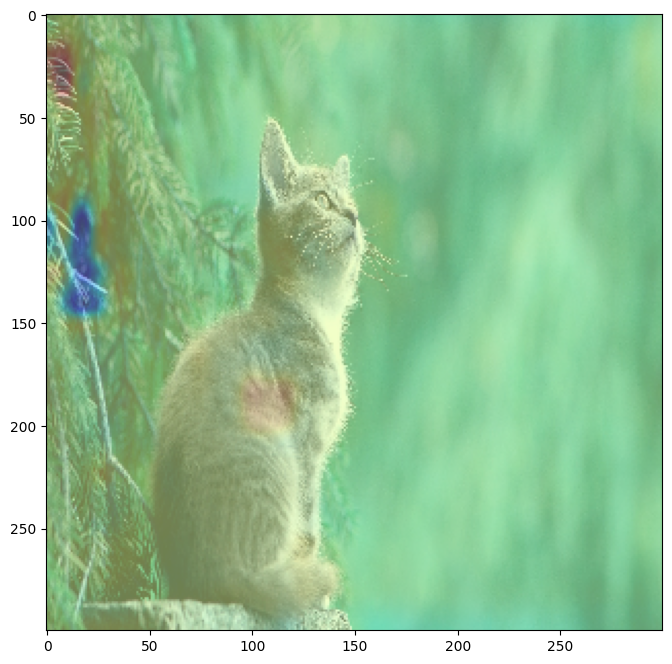

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
sigmoid output: [[0.20302764]]
prediction: cat


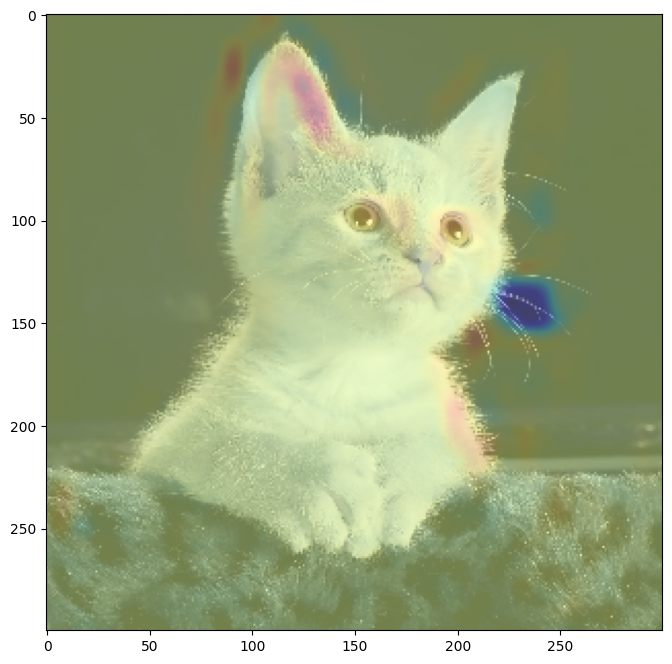

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
sigmoid output: [[0.5855413]]
prediction: dog


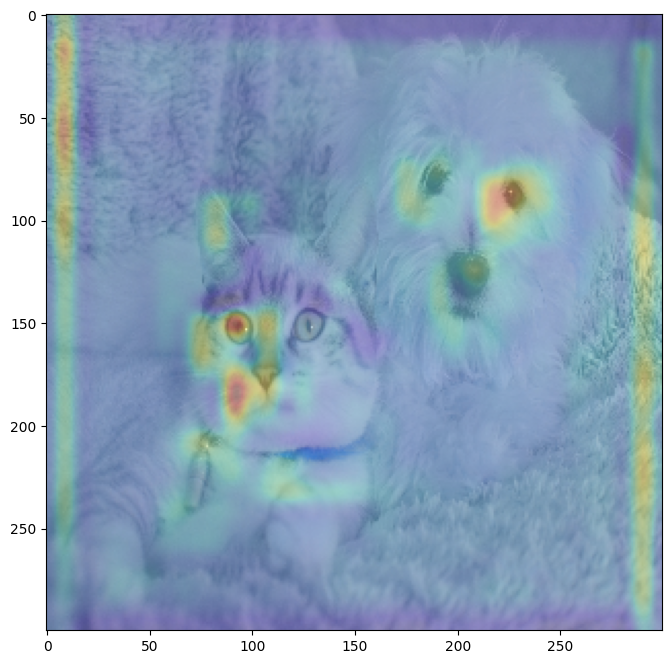

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
sigmoid output: [[0.23107274]]
prediction: cat


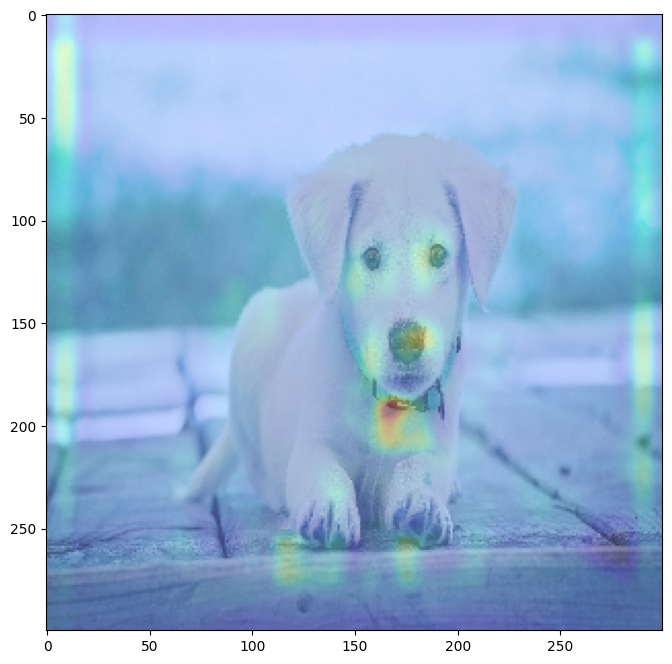

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
sigmoid output: [[0.5837185]]
prediction: dog


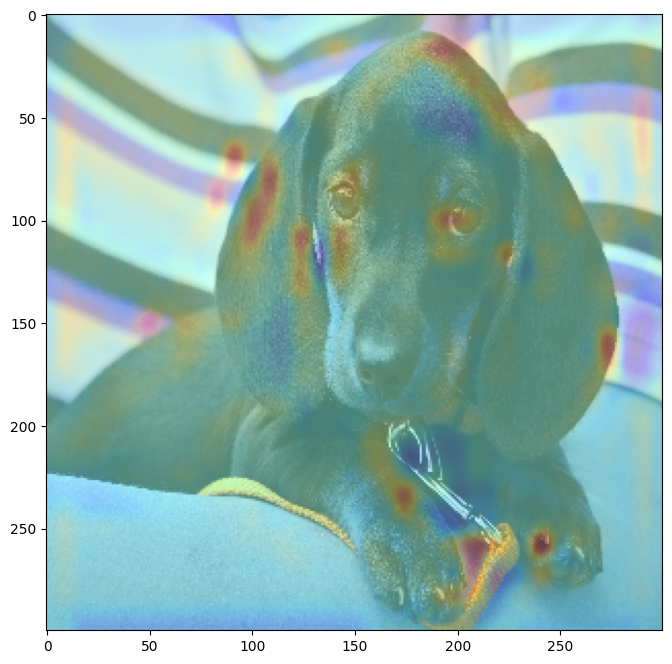

In [9]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

Let's also try it with some of the test images before we make some observations.

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
sigmoid output: [[0.36094728]]
prediction: cat


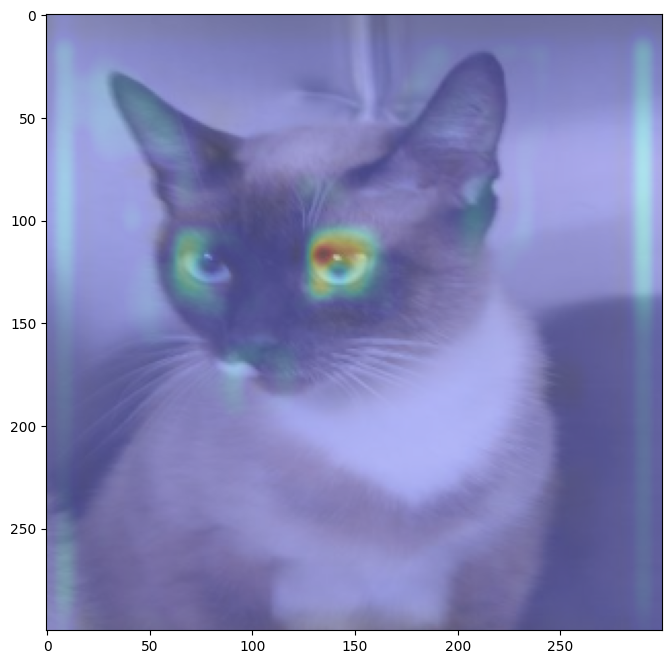

ground truth: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
sigmoid output: [[0.22404881]]
prediction: cat


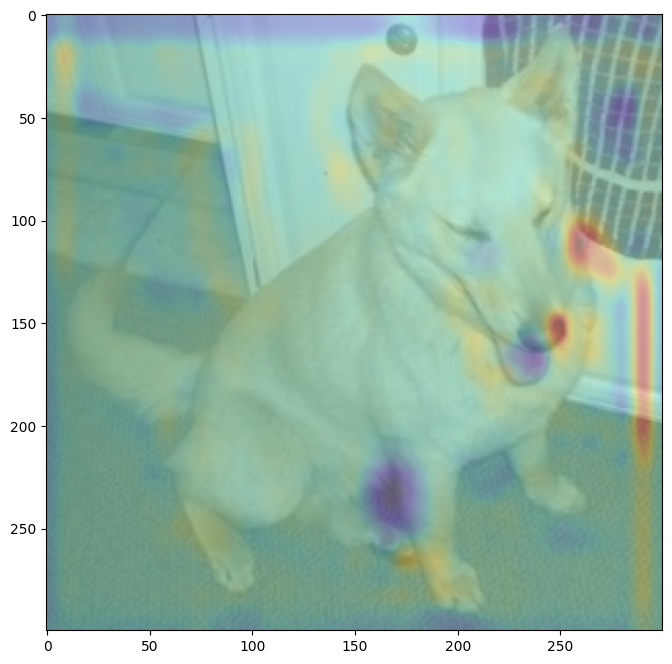

ground truth: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
sigmoid output: [[0.39304432]]
prediction: cat


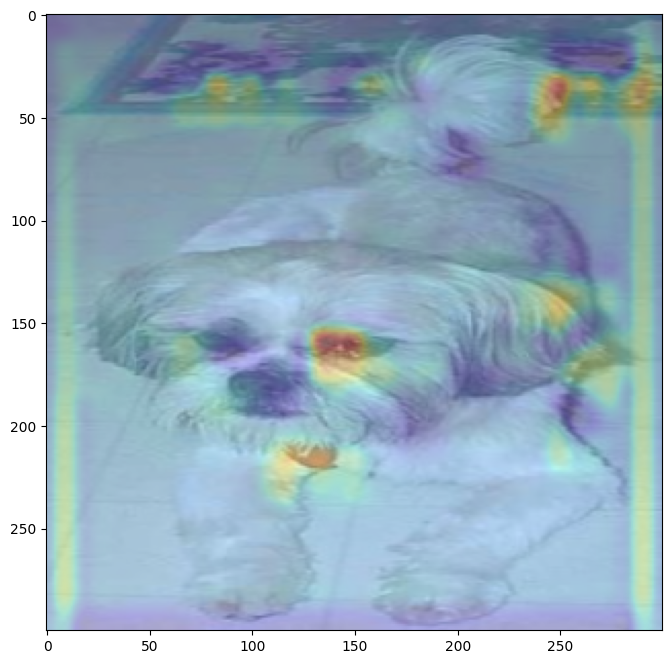

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
sigmoid output: [[0.07925466]]
prediction: cat


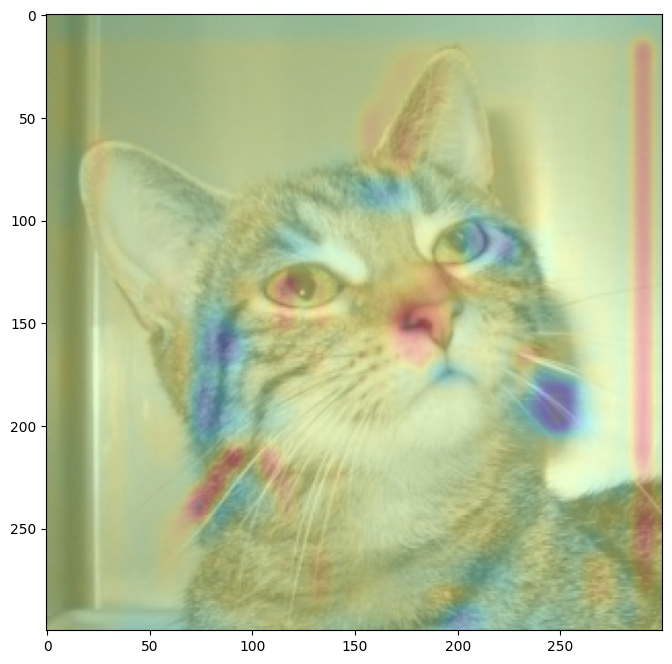

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
sigmoid output: [[0.36166453]]
prediction: cat


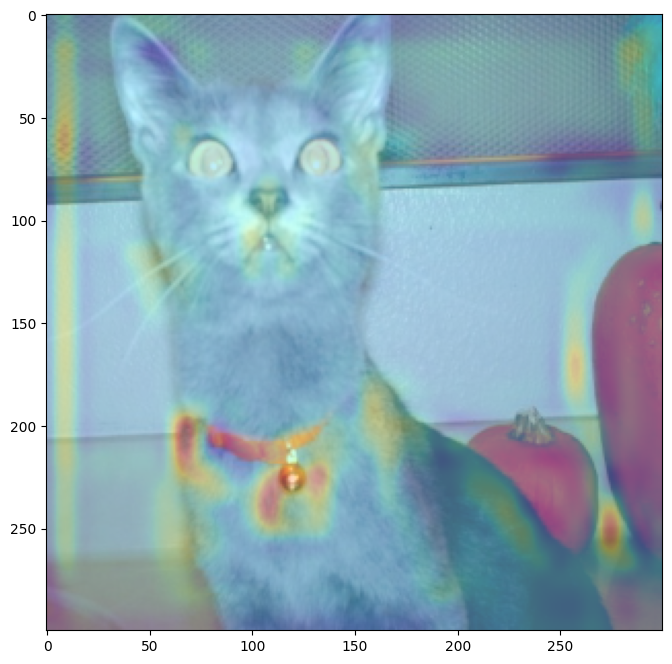

2025-02-07 11:46:00.208897: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)

If your training reached 80% accuracy, you may notice from the images above that the presence of eyes and nose play a big part in determining a dog, while whiskers and a colar mostly point to a cat. Some can be misclassified based on the presence or absence of these features. This tells us that the model is not yet performing optimally and we need to tweak our process (e.g. add more data, train longer, use a different model, etc).